In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.nn import functional as F
from torchvision.utils import make_grid

from swadist.data.loader import get_dataloaders
from swadist.utils import Trainer, show_imgs
from swadist.models.resnet import ResNet

plt.rcParams["savefig.bbox"] = 'tight'
torch.multiprocessing.set_sharing_strategy('file_system')

torch.__version__

'1.10.2'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cpu


In [3]:
# load CIFAR-10
train_loader, valid_loader, test_loader = get_dataloaders(
    dataset="cifar10", num_workers=4, batch_size=16, cuda=device=='cuda'
)

Files already downloaded and verified
Files already downloaded and verified


Training set size: 50000
Validation set size: 50000
Test set size: 10000


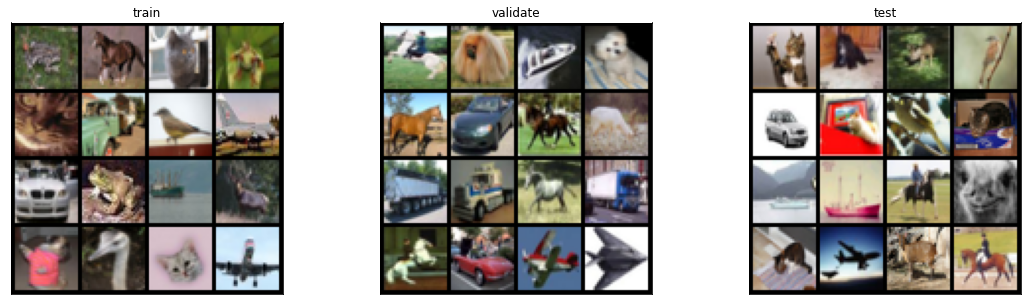

In [4]:
train_data = next(iter(train_loader))
train_grid = make_grid(train_loader.dataset.inv_transform(train_data[0]), nrow=4)

valid_data = next(iter(valid_loader))
valid_grid = make_grid(valid_loader.dataset.inv_transform(valid_data[0]), nrow=4)

test_data = next(iter(test_loader))
test_grid = make_grid(test_loader.dataset.inv_transform(test_data[0]), nrow=4)

show_imgs([train_grid, valid_grid, test_grid], titles=['train', 'validate', 'test'])
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(valid_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

In [22]:
# ~ optimal hyperparms from Shallue et al. 2019 [arXiv: 1811.03600]

# initial lr, scaling factor, momentum
lr0, alpha, gamma = 2**-8.5, 0.25, 0.97

# epochs, lr scaling epochs
epochs, T = 20, 10

stopping_acc=0.9

# lr scaling lambda fun
lr_lambda = lambda epoch: 1 - (1 - alpha)*epoch/T if epoch < T else alpha

# model
resnet8 = ResNet(in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)

optimizer = torch.optim.SGD(resnet8.parameters(), lr=lr0, momentum=gamma, nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, verbose=True)

# begin training
trainer = Trainer(resnet8, F.cross_entropy, optimizer, scheduler, log=True, name='sgd')
trainer(train_loader, valid_loader, epochs=epochs, stopping_acc=stopping_acc, validations_per_epoch=4)

Adjusting learning rate of group 0 to 2.7621e-03.
Starting {epochs}-epoch training loop...
Train epoch: 1 -- Accuracy: 0.369912 -- Avg. loss (cross_entropy): 1.687354 -- Batch: 2813/2813 (100%) -- Total steps: 2813
Validation accuracy: 0.496605 -- Avg. loss (cross_entropy): 1.399813 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 2.5550e-03.
Train epoch: 2 -- Accuracy: 0.532461 -- Avg. loss (cross_entropy): 1.280960 -- Batch: 2813/2813 (100%) -- Total steps: 5626
Validation accuracy: 0.591653 -- Avg. loss (cross_entropy): 1.128908 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 2.3478e-03.
Train epoch: 3 -- Accuracy: 0.605204 -- Avg. loss (cross_entropy): 1.104698 -- Batch: 2813/2813 (100%) -- Total steps: 8439
Validation accuracy: 0.601038 -- Avg. loss (cross_entropy): 1.137651 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 2.1407e-03.
Train epoch: 4 -- Accuracy: 0.653173 -- Avg. loss (cross_entropy): 0.984580 -- Batch: 2813/2813 (100%)

In [ ]:
# retrain on training + validation
trainvalid_loader = get_dataloaders(
    dataset="cifar10", num_workers=4, validation=False, test=False, batch_size=16, cuda=device=='cuda'
)

resnet8 = ResNet(in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)

optimizer = torch.optim.SGD(resnet8.parameters(), lr=lr0, momentum=gamma, nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, verbose=True)

# begin training
trainer = Trainer(resnet8, F.cross_entropy, optimizer, scheduler)
trainer(train_loader, test_loader, epochs=7)

In [8]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

correct = 0
total = 0

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

labels = []
preds = []

with torch.inference_mode():
    for data in test_loader:
        images, target = data
        labels.append(target.numpy())
        outputs = resnet8(images)
        _, predictions = torch.max(outputs, 1)
        preds.append(predictions)
        total += target.size(0)
        correct += (predictions == target).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(target, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Test accuracy: {100 * correct // total}%')
            
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

labels = pd.Series(np.hstack(labels).astype(int), name="Labels")
preds = pd.Series(np.hstack(preds).astype(int), name="Preds")
df_confusion = pd.crosstab(classes[labels], classes[preds])
df_confusion

Test accuracy: 68%
Accuracy for class: plane is 55.3 %
Accuracy for class: car   is 82.5 %
Accuracy for class: bird  is 55.3 %
Accuracy for class: cat   is 51.2 %
Accuracy for class: deer  is 42.4 %
Accuracy for class: dog   is 70.5 %
Accuracy for class: frog  is 72.4 %
Accuracy for class: horse is 78.1 %
Accuracy for class: ship  is 83.5 %
Accuracy for class: truck is 89.2 %


col_0,bird,car,cat,deer,dog,frog,horse,plane,ship,truck
row_0,,,,,,,,,,
bird,553,11,71,38,116,85,46,44,22,14
car,3,825,6,0,7,3,2,0,14,140
cat,64,14,512,18,237,43,56,5,16,35
deer,111,8,93,424,82,89,160,8,16,9
dog,45,13,126,6,705,18,61,3,9,14
frog,47,10,111,12,52,724,15,4,11,14
horse,16,4,39,18,85,2,781,8,3,44
plane,62,30,32,20,17,11,23,553,171,81
ship,9,24,15,1,12,5,6,24,835,69
